# Исследование рынка видеоигр
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xboxили PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. 
Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## 1. Изучение данных

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
games = pd.read_csv('datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные выглядят очень даже неплохо, хоть и не без изъянов.

Посмотрим на общую информацию о датафрейме и проверим его на дубликаты.

In [3]:
print('Количество дубликатов равно', games[games.duplicated()]['Name'].count()) 
games.info()

Количество дубликатов равно 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Отлично, дубликатов нет. Но видно большое количество пропусков в столбцах, отвечающих за рейтинги игр. Такие пропуски никак не заполнить, придется оставить их так. Но все другие пропуски надо обязательно обработать.

## 2. Подготовка данных

In [4]:
games.columns = games.columns.str.lower()

Приводим названия столбцов к нижнему регистру

In [5]:
games = games.dropna(subset=['name', 'year_of_release'])
#games.info()

Удаляем строки с пропусками в столбцах 'name' и 'year_of_release'

In [6]:
games.insert(8,'total_sales', 0)
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games = games.loc[games['total_sales'] != 0]

Создаем новый столбец 'total_sales' и записываем в него суммарные продажи во всех регионах

In [7]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
print(games['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


'tbd', он же To Be Determined (будет определено) или To Be Decided (будет решено). По сути никакой существенной разницы между nan и tbd (по крайней мере в данном случае) нет, так что просто заменяем все 'tbd' на nan

In [8]:
games['year_of_release'] = games['year_of_release'].astype('int')
games['user_score'] = games['user_score'].astype('float')

Приводим столбцы 'year_of_release' и 'user_score' к целочисленному и вещественному типу данных соответственно

In [9]:
games['rating'] = games['rating'].fillna('Other')

Пропуски в столбце 'rating' мы можем обработать только таким способом. Эта обработка пригодиться при дальнейшем анализе данных

In [10]:
games.reset_index(drop=True, inplace=True)
print(games.head())
games.info()

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  total_sales  critic_score  user_score  \
0     28.96      3.77         8.45        82.54          76.0         8.0   
1      3.58      6.81         0.77        40.24           NaN         NaN   
2     12.76      3.79         3.29        35.52          82.0         8.3   
3     10.93      3.28         2.95        32.77          80.0         8.0   
4      8.89     10.22         1.00        31.38           NaN         NaN   

  rating  
0      E  
1  Other  
2      E  
3     

И, наконец, сбрасываем индекс всего датафрейма. 

Названия столбцов приведены к нижнему регистру, обработано значение 'tbd' в столбце 'user_score', создан столбец 'total_sales' с суммарными продажами игры во всех регионах, столбцы по возможности приведены к нужным типам данных, пропуски в столбцах 'name' и 'year_of_release' удалены, пропуски в столбце 'rating' обработаны соответствующим способом.

Пропуски в столбцах 'critic_score' и 'user_score' я решил не обрабатывать, так как никак кроме удаления их нельзя обработать, а удаление приведет у потере большого количества данных, нужных для дальнейшего анализа. Причиной же, по которой так много пропусков в этих столбцах, вероятно служит малоизвестность и/или приличный возраст игры, из-за чего оценки попросту отсутствуют.

Подготовка данных готова

## 3. Исследовательский анализ данных

### 3.1 Сколько игр выпускалось в разные годы?

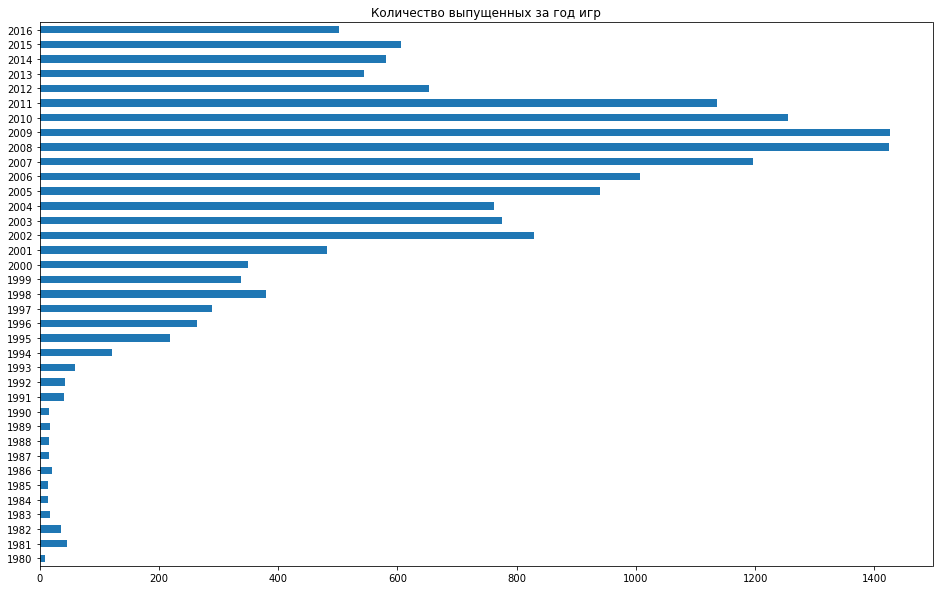

In [11]:
games.groupby(by='year_of_release').agg({'year_of_release':'count'}).rename(
    columns={'year_of_release':'count'}).plot(kind = 'barh', figsize=(16, 10), legend = False)
plt.ylabel('')
plt.title('Количество выпущенных за год игр');

Для исследования в целях планирования компании на 2017 данные за 80-е и 90-е являются совершенно не актуальными. Даже данные за нулевые будет сомнительно использовать в исследовании. Я думаю, что наилучшим для исследования решением будет анализ данных за последние 5 лет. В игровой индустрии очень важно следить за трендами, и именно тенденции последних лет подскажут нам, на какой продукт лучше всего обратить внимание. 

In [12]:
actual = games[games['year_of_release'] > 2011]

### 3.2 Как менялись продажи по платформам?

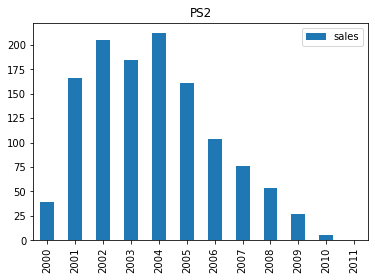

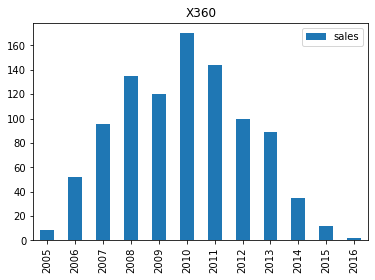

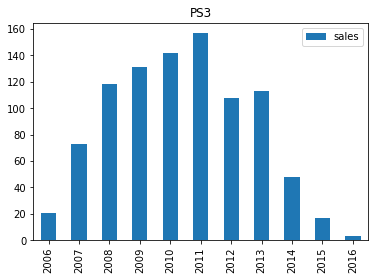

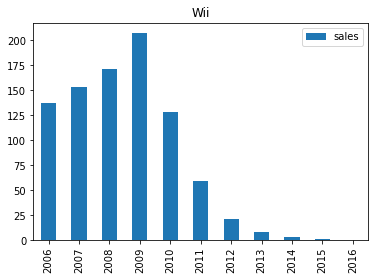

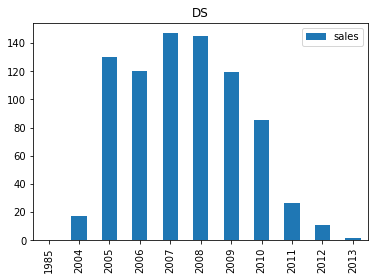

In [13]:
platform = games.groupby(by='platform').agg({'total_sales':'sum'}).rename(columns={'total_sales':'sales'}).reset_index().sort_values(by='sales', ascending = False)
platform_top = platform.head(5)
graphic = games[games['platform'].isin(platform_top['platform'])].reset_index().groupby(by=['platform','year_of_release']).agg({'total_sales':'sum'}).rename(columns={'total_sales':'sales'}).reset_index().sort_values(by=['platform','year_of_release','sales'], ascending = True)
for pl in platform_top['platform']:
    graphic[graphic['platform'] == pl].plot(x='year_of_release', y='sales', kind='bar', title=pl, xlabel = '', figsize=(6,4))

PS2 хоть и держит пальму первенства по суммарным продажам, но за последние 5 с лишним лет на ней не вышла ни одна игра, что означает, что платформа "умерла". Тоже самое касается Nintendo DS и Wii. Конечно энтузиасты всё еще играют на этих консолях, но нас интересуют актуальные консоли, на которые выходят новые игры, которые в свою очередь приносут прибыль.

С PS3 и Xbox360 ситуация другая. Продажи очень сильно просели относительно 2007-13 годов, но они есть, а значит игры на этих платформах всё ещё выходят и приносят какие-никакие деньги. Это следует учитывать при дальнейшем анализе.

### 3.3 За какой характерный срок появляются новые и исчезают старые платформы?

В среднем игровые консоли живут 7.68 лет


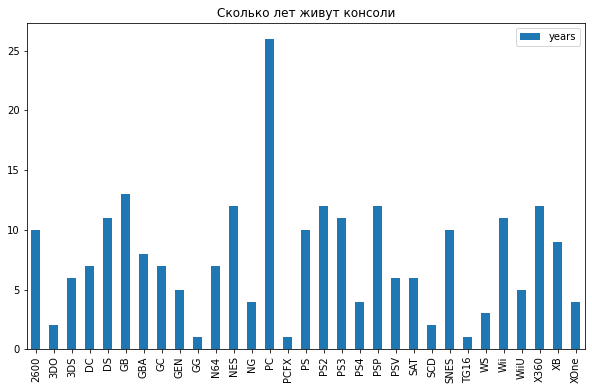

In [14]:
year = games.groupby(by='platform').agg({'year_of_release':'nunique'}).rename(columns={'year_of_release':'years'}).reset_index()
games.groupby(by='platform').agg({'year_of_release':'nunique'}).rename(columns={'year_of_release':'years'}).reset_index().plot(x='platform', y='years', kind='bar', title='Сколько лет живут консоли', xlabel = '', figsize=(10,6))
print('В среднем игровые консоли живут', round(year['years'].mean(), 2), 'лет')

В среднем игровым платформам удается прожить 7 - 8 лет. Возможно они бы жили дольше, но благодаря постоянному прогрессу выходят всё новые игровые консоли, которые выжимают с рынка старые.

### 3.4 Какие платформы лидируют по продажам, растут или падают?

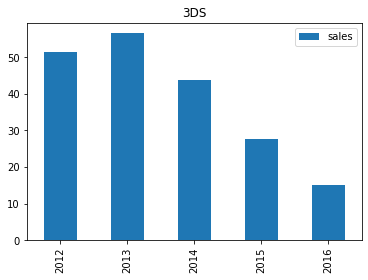

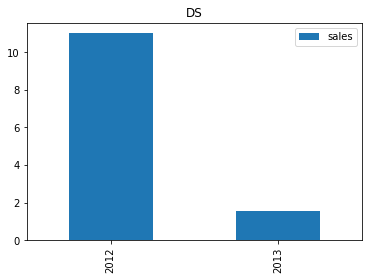

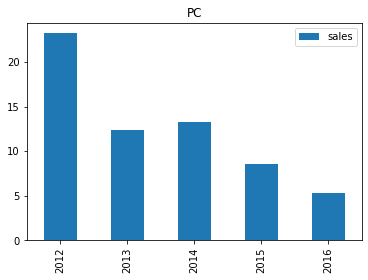

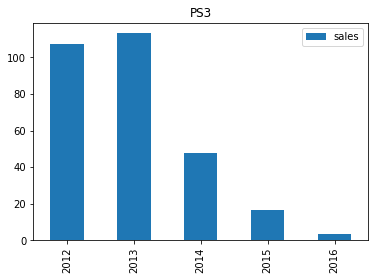

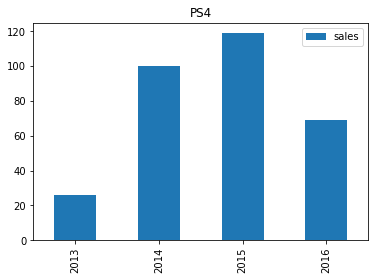

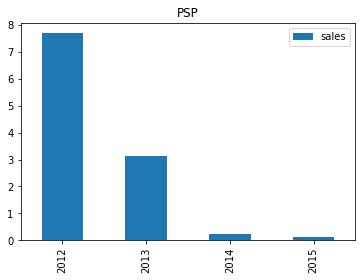

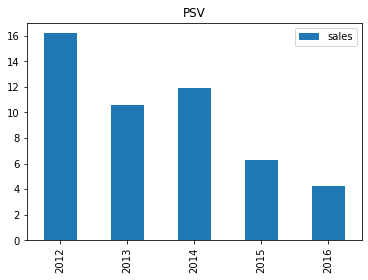

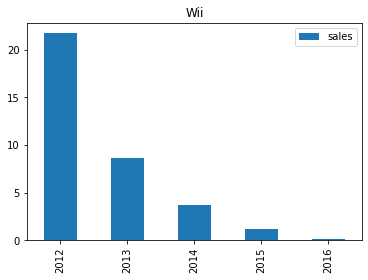

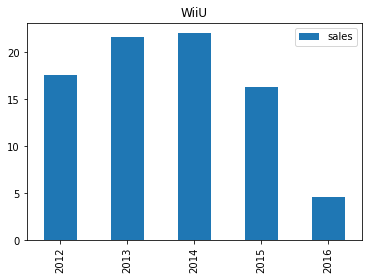

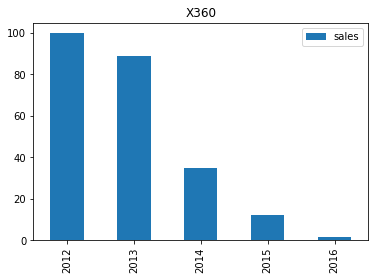

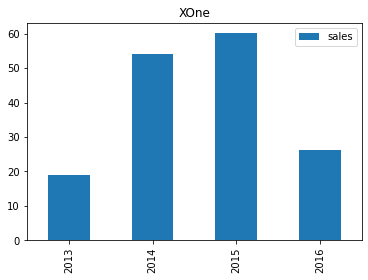

In [15]:
actual_2 = actual.groupby(by=['platform','year_of_release']).agg({'total_sales':'sum'}).rename(columns={'total_sales':'sales'}).reset_index().sort_values(by=['platform','year_of_release'], ascending = True)
platforms = actual_2['platform'].unique()
for p in platforms:
    actual_2[actual_2['platform'] == p].plot(x='year_of_release', y='sales', kind='bar', title=p, xlabel = '')

Безоговорочным лидером в 2016 году стала платформа PlayStation 4 с прибылью в 70млн. Также неплохо себя показали платформы XOne, 3DS и PC, хоть показатели у них и хуже чем в прошлые годы.

Прибыль нескольких платформ стремительно падает в последние годы, как например у X360, WiiU, PS3 и PSV, что делает их непригодными для серьёзных вложений. 

Другие платформы получили мизерную прибыль или не получили никакую прибыль вовсе. 

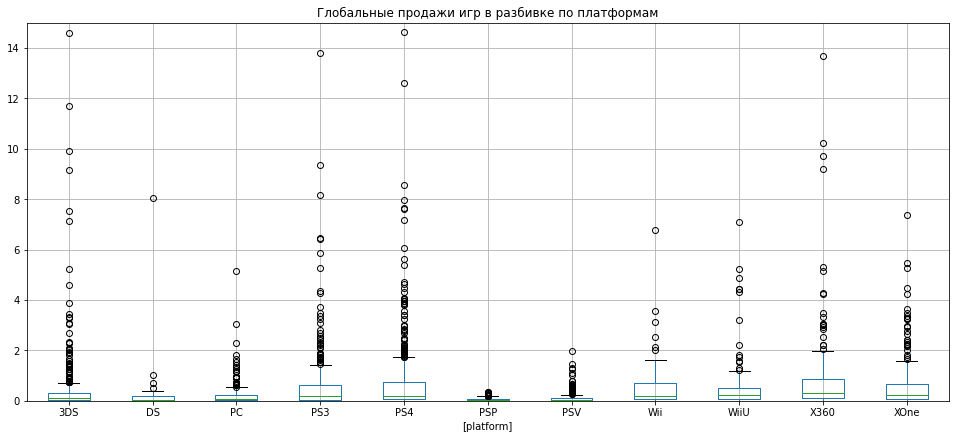

In [16]:
actual.boxplot(column=['total_sales'], by=['platform'], figsize=(16,7)).set_ylim(0, 15)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle(None)
plt.show()

На графике видно множество выбросов, что затрудняет анализ. Давайте посмотрим на данные поближе

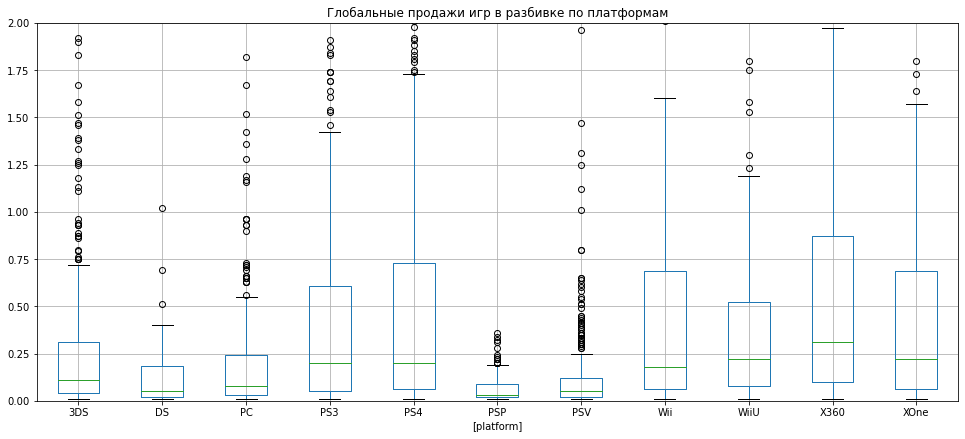

In [17]:
actual.boxplot(column=['total_sales'], by=['platform'], figsize=(16,7)).set_ylim(0, 2)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.suptitle(None)
plt.show()

У топовых платформ медиана варьируется в пределах 0.2-0.3млн за игру. У остальных она на уровне 0.05-0.2млн.

Верхняя граница предела, за которым уже определяются аномалии у платформ PS3, PS4, X360, XOne и Wii на уровне 1.2-2млн прибыли за игру. У остальных в пределах 0.75 миллионов.

Две платформы с самыми сочными показателями - это PS4 и X360. У PlayStation 4 медиана примерно равна 0.2млн прибыли за игру, а у Xbox360 0.3млн. Верхний предел у PlayStation 4 равна ~1.7млн, а у Xbox360 ~2млн.

Самые же плачевные показателями у PSP и PSV. Медиана у них в пределах 0.1млн прибыли за игру, а верхний предел не превышает 0.25млн.

### 3.5 Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков?

Влияние оценок критиков на продажи PS3: 0.3315
Влияние пользовательских оценок на продажи PS3: -0.0051


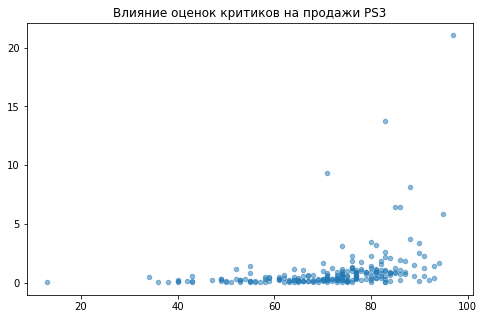

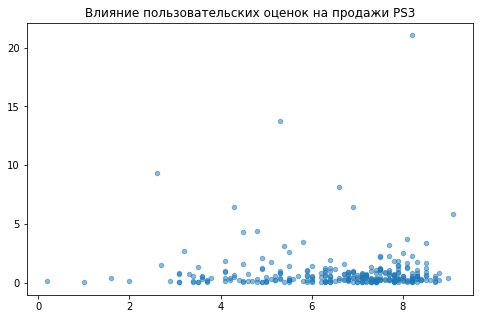

In [18]:
ps3 = actual[actual['platform'] == 'PS3']
ps3.plot(x='critic_score', y='total_sales', kind = 'scatter', alpha = 0.5, title='Влияние оценок критиков на продажи PS3', xlabel = '', ylabel = '', figsize=(8,5))
print('Влияние оценок критиков на продажи PS3:', round(ps3['critic_score'].corr(ps3['total_sales']), 4))
ps3.plot(x='user_score', y='total_sales', kind = 'scatter', alpha = 0.5, title='Влияние пользовательских оценок на продажи PS3', xlabel = '', ylabel = '', figsize=(8,5))
print('Влияние пользовательских оценок на продажи PS3:', round(ps3['user_score'].corr(ps3['total_sales']), 4))

Возьмем для проверки PS3. Расчеты корреляции и построенные диаграммы рассеяния показывают, что рейтинги критиков имеют влияние на продажи, а вот пользовательские оценки нет.

Влияние оценок критиков на общие продажи: 0.3082
Влияние пользовательских оценок на общие продажи: 0.0044


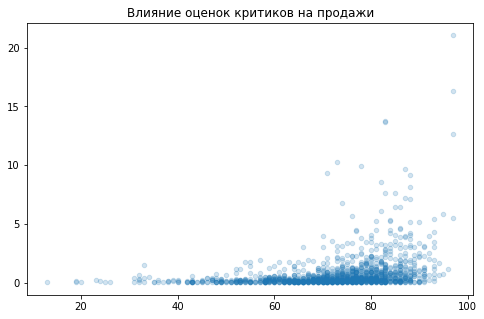

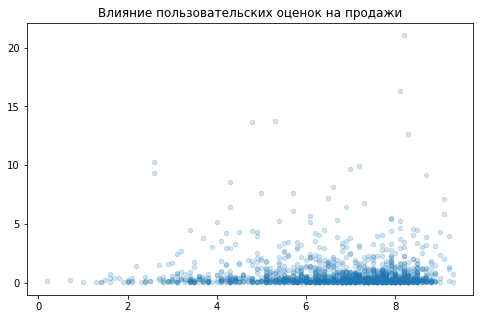

In [19]:
actual.plot(x='critic_score', y='total_sales', kind = 'scatter', alpha = 0.2, title='Влияние оценок критиков на продажи', xlabel = '', ylabel = '', figsize=(8,5))
print('Влияние оценок критиков на общие продажи:', round(actual['critic_score'].corr(actual['total_sales']), 4))
actual.plot(x='user_score', y='total_sales', kind = 'scatter', alpha = 0.2, title='Влияние пользовательских оценок на продажи', xlabel = '', ylabel = '', figsize=(8,5))
print('Влияние пользовательских оценок на общие продажи:', round(actual['user_score'].corr(actual['total_sales']), 4))

Теперь возьмем для проверки весь датафрейм за актуальный период. Расчеты корреляции и построенные диаграммы рассеяния показывают, что, как и в случае отдельно взятой платформы, рейтинги критиков имеют влияние на продажи, а пользовательские оценки все также мизерно влияют на продажи.

### 3.6 Общее распределение игр по жанрам

In [20]:
genre = actual.groupby(by='genre').agg({'name': 'count', 'total_sales': 'sum'}).rename(columns={'name':'count'}).reset_index()
genre.loc[:, 'per_game'] = genre['total_sales']/genre['count']
display(genre[['genre', 'count']].sort_values(by='count', ascending = False).head())
display(genre[['genre', 'total_sales']].sort_values(by='total_sales', ascending = False))
display(genre[['genre', 'per_game']].sort_values(by='per_game', ascending = False).head(8))

,genre,count
0,Action,1031
7,Role-Playing,370
1,Adventure,302
10,Sports,268
8,Shooter,235


,genre,total_sales
0,Action,441.12
8,Shooter,304.73
7,Role-Playing,192.80
10,Sports,181.07
3,Misc,85.04
4,Platform,61.00
6,Racing,53.50
2,Fighting,44.49
9,Simulation,35.12
1,Adventure,29.43


,genre,per_game
8,Shooter,1.296723
4,Platform,0.717647
10,Sports,0.675634
7,Role-Playing,0.521081
6,Racing,0.465217
3,Misc,0.442917
9,Simulation,0.439000
0,Action,0.427856


Высоким спросом могут похвастаться игры с жанрами: Экшен, Ролевые, Шутер и Спорт. Их можно считать самыми прибыльными жанрами.

Самые низкие продажи у игр с жанрами: Головоломки, Стратегия, Приключения, Симулятор и Файтинг. Что делает их нежелательными для вложений. Особенно игры с жанром Приключения, ведь 302 вышедшие за последние 5 лет (3 место между прочем) продались суммарно всего 29млн раз (тоже 3 результат, но уже с конца).  

Ещё интересным критерием может служить средние продажи в каждом жанре. Например шутер игру покупают в среднем 1.2млн раз. А такие популярные экшен игры в среднем продаются только 0.42млн раз. 

Так что принадлежность игры к хорошо продаваемому жанру ещё не гарантирует 100% хорошую продаваемость.

## 4. Портрет пользователя каждого региона

### 4.1 Самые популярные платформы

In [39]:
list = ['na_sales','eu_sales','jp_sales']
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]], 
                    subplot_titles=[list[0][0:2].upper(), list[1][0:2].upper(), list[2][0:2].upper()])
col = 0
for val in list:
    platform = actual.groupby(by='platform').agg({val:'sum'}).sort_values(by=val, ascending = False).reset_index()
    platform_top = actual.groupby(by='platform').agg({val:'sum'}).sort_values(by=val, ascending = False).reset_index().head(5)
    platform['platform'] = np.where(~platform['platform'].isin(platform_top['platform']),'Other', platform['platform'])
    col += 1
    fig.add_trace(go.Pie(labels=platform['platform'], values=platform[val], sort=False, showlegend=False), 1, col)

fig.update_traces(textposition='inside', textinfo='label+percent', texttemplate="%{label}<br>%{percent:.0%}",
                  hoverinfo="percent+label", hovertemplate="%{label}<br>%{percent:.1%}<extra></extra>")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.layout.annotations[0].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[1].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[2].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.show()

Заметно доминирование PlayStation и Xbox на игровом рынке. Особенно это ощущается на американском и европейском рынках, где они удерживают значительные доли от суммарных продаж игр на всех игровых платформ. В обоих регионах игровые консоли от этих брендов занимают по 4 позиции в топ-5. 

Но различия имеются. Американские продажи PlayStation и Xbox примерно равны, если суммировать выручки консолей разных поколений. А вот на европейском рынке PlayStation занимает практически половину всех продаж, а Xbox только четверть, уступая PS в 2 раза.

Японский регион отличается от американского и европейского. Почти половина всех продаж приходиться на платформу Nintendo 3DS, пользующуюся невероятной популярностью у японских геймеров. Игровые консоли линейки PlayStation тоже популярны в Японии, ведь в топ-5 их целых 3 - PSV, PS3 и PS4. А вот Xbox вовсе не вошел в топ-5.

### 4.2 Самые популярные жанры 

In [36]:
list = ['na_sales','eu_sales','jp_sales']
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]], 
                    subplot_titles=[list[0][0:2].upper(), list[1][0:2].upper(), list[2][0:2].upper()])
col = 0
for val in list:
    genre = actual.groupby(by='genre').agg({val:'sum'}).sort_values(by=val, ascending = False).reset_index()
    genre_top = actual.groupby(by='genre').agg({val:'sum'}).sort_values(by=val, ascending = False).reset_index().head(5)
    genre['genre'] = np.where(~genre['genre'].isin(genre_top['genre']),'Other', genre['genre'])
    col += 1
    fig.add_trace(go.Pie(labels=genre['genre'], values=genre[val], sort=False, showlegend=False), 1, col)

fig.update_traces(textposition='inside', textinfo='label+percent', texttemplate="%{label}<br>%{percent:.0%}",
                  hoverinfo="percent+label", hovertemplate="%{label}<br>%{percent:.1%}<extra></extra>")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.layout.annotations[0].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[1].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[2].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.show()

Игроки из Северной Америки и Европы очень схожи во вкусах - 2/3 всех продаж приходится на шутеры, спортивные и экшен направленные игры. 

Единственным бросающимся отличием между этими регионами - это любовь европейских геймеров к гонкам, а американских к музыкальным играм.

В Японии значительная доля всех продаж приходится на ролевые игры (34%). К сравнению, доля продаж ролевых игр в Америке и Европе составляет всего ~10%. Экшен направленные игры в Японии пользуются огромным спросом, почти таким же как и в других регионах (в процентном соотношении). Также японские геймеры охотно покупают музыкальные игры, симуляторы и файтинги.

### 4.3 Влияние рейтинга ESRB на продажи в отдельном регионе

In [38]:
list = ['na_sales','eu_sales','jp_sales']
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]], 
                    subplot_titles=[list[0][0:2].upper(), list[1][0:2].upper(), list[2][0:2].upper()])
col = 0
for val in list:
    rating = actual.groupby(by='rating').agg({val:'sum'}).sort_values(by=val, ascending = False).reset_index()
    col += 1
    fig.add_trace(go.Pie(labels=rating['rating'], values=rating[val], sort=True, showlegend=False), 1, col)

fig.update_traces(textposition='inside', textinfo='label+percent', texttemplate="%{label}<br>%{percent:.0%}",
                  hoverinfo="percent+label", hovertemplate="%{label}<br>%{percent:.1%}<extra></extra>")
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
fig.layout.annotations[0].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[1].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.layout.annotations[2].update(y = 0.8, font = dict(size=22, family='Verdana', color='black'))
fig.show()

Рейтинг ESRB естественно влияет на продажи. Игры с рейтингами E, M, T и E10+ продаются многомилионными тиражами во всех регионах, а игры с рейтингами K-A, AO, EC и RP вовсе не попали в выборку выпущенных за последние 5 лет игр.

Процентное соотношение продаж на американском и европейском рынках очень схоже. Игры с рейтингом M («Mature» — от 17 лет) занимают около 40% всех проданных игр в Америке и Европе. Игры с рейтингом E («Everyone» — от 6 лет) вторые по популярности и занимают примерно 1/5 продаж в обоих регоинах. Оставшиеся ~40% продаж делят игры с рейтингами E10+ («Everyone 10 and older» — от 10 лет) и T («Teen» — от 13 лет), которые занимают по 10-13% от всех продаж, а также игры с неизвестным рейтингом ('Other'), занимающие относительно небольшую нишу от общих продаж, составляющую ~17,5% в обоих регионах.

Японский регион как всегда отличается от западных. Игры с неизвестыми рейтингами покрывают целых 56% от общих продаж! Это сильно затруднит анализ, как и составление достоверного вывода. Но работаем с тем, что есть. 
Игры с рейтингами E и T покрывают по ~14% продаж. Игры с рейтингом M занимают всего 11% продаж. А у игр E10+ вовсе 4% от общих продаж. Следовательно, игры с более возрастным рейтингом M в Японии менее популярны, чем охватывающие бóльшие возрастные группы игры с рейтингами E и T.

## 5. Проверка гипотез

### 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 

Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [24]:
print('XOne:', round(actual[actual['platform'] == 'XOne']['user_score'].mean(), 2))
print('PC:  ', round(actual[actual['platform'] == 'PC']['user_score'].mean(), 2))

alpha = 0.05
xbox_one_ratings = actual[(actual['platform'] == 'XOne') & (actual['user_score'] > 0)]['user_score']
pc_ratings = actual[(actual['platform'] == 'PC') & (actual['user_score'] > 0)]['user_score']
results = st.ttest_ind(xbox_one_ratings, pc_ratings)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

XOne: 6.52
PC:   6.43
p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Проверяем нулевую гипотезу используя ttest. p-значение равно 0.55, значит нулевая гипотеза правдива. 

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### 5.2 Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports одинаковые. 

Альтернативная гипотеза - средние пользовательские рейтинги жанров Action и Sports разные.

In [25]:
print('Action:', round(actual[actual['genre'] == 'Action']['user_score'].mean(), 2))
print('Sports:', round(actual[actual['genre'] == 'Sports']['user_score'].mean(), 2))

alpha = 0.05
action_ratings = actual[(actual['genre'] == 'Action') & (actual['user_score'] > 0)]['user_score']
sports_ratings = actual[(actual['genre'] == 'Sports') & (actual['user_score'] > 0)]['user_score']
results_1 = st.ttest_ind(action_ratings, sports_ratings)
print('p-значение:', results_1.pvalue)

if (results_1.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Action: 6.83
Sports: 5.46
p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Проверяем нулевую гипотезу используя ttest. p-значение достаточно мало, значит мы можем отвергнуть нулевую гипотезу и принять альтернативную как истинную. Средние пользовательские рейтинги жанров Action и Sports разные

## 6. Общий вывод

Был проведен обширный анализ данных для составления рекомендаций, которые должны помочь сделать ставку на потенциально популярный продукт и спланировать рекламную кампанию в 2017 году.

Очень важно помнить о различиях в предпочтениях в разных регионах и "сроке жизни" игровой платформы (7-8 лет). Через несколько лет PS4, показывающую сейчас прекрасные результаты подвинет новая PS5, и тогда стоит переключить вложения на новинку.

1. Рекомендации по игровым платформам:

- Однозначно стоит вложиться в PlayStation 4, которая показала лучший результат по прибыли в 2016 году.
- Также стоит присмотреться платформам XOne, 3DS и PC, которые потенциально смогут отбить грамотные вложения.
- В японском сегменте рынка однозначно надо вкладываться в 3DS, доминирующую там.

2. Рекомендации по жанрам:

- Если брать европейские и американский регионы, то наилучшие игры для вложений - это шутеры, экшен направленные и спортивные игры.
- Для японского рынка самыми предпочтительными будут ролевые игры. Также хорошо продаются экшен направленные игры.

3. Рекомендации по рейтингу ESRB:

- Игры с рейтингом M («Mature» — от 17 лет) занимают почти половину всех проданных игр в Америке и Европе.
- Также хорошо продаются игры с рейтингом E («Everyone» — от 6 лет).
- Игры с высоким возрастным рейтингом посредственно продаются в Японии. 

4. Отрицательные рекомендации:

- НЕ вкладываться в сильно сдающие последние годы свои позиции платформы: X360, WiiU, PS3, PSV и другие.
- НЕ вкладываться в игры с жанрами: Головоломки, Стратегия, Приключения, Симулятор.

Это все общие рекомендации, которые должны будут помочь сделать ставку на потенциально прибыльный продукт. 

Также надо помнить, что при выборе игры надо опираться не только на несколько общих рекомендаций, но подвергать детальному анализу конкретную игру.